In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import edhec_risk_ph as erk
%load_ext autoreload
%autoreload 2

In [2]:
erk.bond_cash_flows(3,100,0.03,2)

1      1.5
2      1.5
3      1.5
4      1.5
5      1.5
6    101.5
dtype: float64

In [3]:
erk.bond_price(20,1000,0.05,2,0.06)

0    884.42614
dtype: float64

In [4]:
rates = np.linspace(0.01,0.10,num=20)
rates

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

<Axes: title={'center': 'Bond Price vs Yield'}, xlabel='Yield', ylabel='Price'>

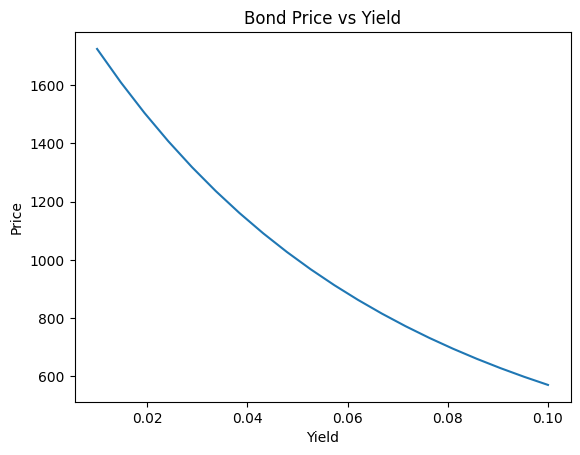

In [5]:
prices = [erk.bond_price(20,1000,0.05,2,r) for r in rates]
pd.DataFrame(data=prices,index=rates).plot(title='Bond Price vs Yield',ylabel='Price',xlabel='Yield',legend=False)

In [6]:
cf = erk.bond_cash_flows(3,1000,0.06,2)
cf

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [7]:
discounts = erk.discount(cf.index,0.06/2)
discounts

,0
1,0.970874
2,0.942596
3,0.915142
4,0.888487
5,0.862609
6,0.837484


In [8]:
dcf = discounts[0] * cf
dcf

1     29.126214
2     28.277877
3     27.454250
4     26.654611
5     25.878264
6    862.608784
dtype: float64

In [9]:
weights = dcf/dcf.sum()
weights

1    0.029126
2    0.028278
3    0.027454
4    0.026655
5    0.025878
6    0.862609
dtype: float64

In [10]:
(cf.index*weights).sum()

np.float64(5.579707187194534)

In [11]:
erk.macaulay_duration(cf,0.06/2)

np.float64(5.579707187194534)

In [13]:
## duration matching
liabilities = pd.Series(data=[100000,100000],index=[10,12])
erk.macaulay_duration(liabilities,0.04)

np.float64(10.960799385088393)

In [14]:
#say we only have bonds with 10 and 20 year durations
#we want to consturct a portfolio with duration of 11 years
md_10 = erk.macaulay_duration(erk.bond_cash_flows(10,1000,.05,1),0.04)
md_20 = erk.macaulay_duration(erk.bond_cash_flows(20,1000,.05,1),0.04)

In [15]:
md_10,md_20

(np.float64(8.190898824083233), np.float64(13.544718122145921))

In [17]:
#now we need to solve for weights w_10 and w_20
#11 = w_10*md_10 + w_20*md_20

short_bond = erk.bond_cash_flows(10,1000,.05,1)
long_bond = erk.bond_cash_flows(20,1000,.05,1)
w_s = erk.match_durations(liabilities, short_bond,long_bond, 0.04)
w_s

np.float64(0.48263092069478974)

In [31]:
p_short = erk.bond_price(10,1000,.05,1,0.04).values[0]
p_long = erk.bond_price(20,1000,.05,1,0.04).values[0]
a_0 = 130000
p_flows = pd.concat([a_0*w_s/p_short*short_bond,
                     a_0*(1-w_s)/p_long*long_bond])
erk.macaulay_duration(p_flows,0.04)

np.float64(10.960799385088393)

In [32]:
erk.macaulay_duration(liabilities,0.04)

np.float64(10.960799385088393)

In [33]:
cfr = erk.funding_ratio(p_flows,liabilities,0.04)
cfr

0    0.999876
dtype: float64

<Axes: title={'center': 'Funding Ratio vs Yield'}, xlabel='Yield', ylabel='Funding Ratio'>

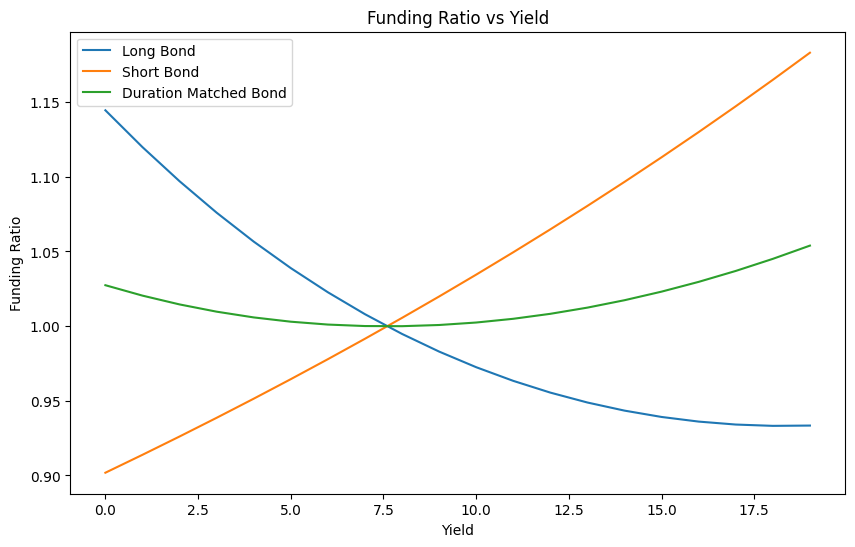

In [41]:
rates = np.linspace(0.0,0.10,num=20)
lb_assets = a_0*long_bond/p_long
sb_assets = a_0*short_bond/p_short
fr_change = pd.DataFrame({
    "Long Bond": [erk.funding_ratio(lb_assets,liabilities,r).values[0] for r in rates],
    "Short Bond": [erk.funding_ratio(sb_assets,liabilities,r).values[0] for r in rates],
    "Duration Matched Bond": [erk.funding_ratio(p_flows,liabilities,r).values[0] for r in rates]
}
)

fr_change.plot(title='Funding Ratio vs Yield',xlabel='Yield',ylabel='Funding Ratio',figsize=(10,6))